In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
path = './drive/MyDrive/Materiale_Pellegrino_personal/AndMal2017/AndMal_Shuffled.csv'
dataset = pd.read_csv(path)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train = dataset[0:50259].copy()
test = dataset[50259:].copy()

# elimino la riga e resetto l'indice
test = test.drop(index=36889+50259)
test = test.reset_index(drop=True)
test = test.drop(index=37822)
test = test.reset_index(drop=True)

In [4]:
# Tolgo gli spazi dalle etichette delle colonne
train.columns = [x.replace(" ", "") for x in train.columns]
test.columns = [x.replace(" ", "") for x in test.columns]

""" Il dataset presentava all'interno della stessa colonna, per ogni features, valori di tipo diverso.
  Ho distinto quelli interi da quelli continui e ho convertito per uniformarli """

# convert columns to int64 dtype
train = train.astype({"Protocol": int, "FlowDuration": int, 'TotalFwdPackets':int, 'TotalBackwardPackets':int,'TotalLengthofFwdPackets':int, 'TotalLengthofBwdPackets':int,
                'FwdPacketLengthMax':int, 'FwdPacketLengthMin':int, 'BwdPacketLengthMax':int, 'BwdPacketLengthMin':int, 'FwdPSHFlags':int, 'BwdPSHFlags':int,
                'FwdURGFlags':int, 'BwdURGFlags':int, 'MinPacketLength':int, 'MaxPacketLength':int, 'FINFlagCount':int, 'SYNFlagCount':int, 
                'RSTFlagCount':int, 'PSHFlagCount':int, 'ACKFlagCount':int, 'URGFlagCount':int, 'CWEFlagCount':int, 'ECEFlagCount':int, 'Down/UpRatio':int,
                'FwdAvgBytes/Bulk':int, 'FwdAvgPackets/Bulk':int, 'FwdAvgBulkRate':int, 'BwdAvgBytes/Bulk':int, 'BwdAvgPackets/Bulk':int, 'BwdAvgBulkRate':int,
                'SubflowFwdPackets':int, 'SubflowFwdBytes':int, 'SubflowBwdPackets':int, 'SubflowBwdBytes':int, 'Init_Win_bytes_forward':int, 
                'Init_Win_bytes_backward':int, 'act_data_pkt_fwd':int, 'min_seg_size_forward':int})

# convert columns to float64 dtype
train = train.astype({'FwdPacketLengthMean':float, 'FwdPacketLengthStd':float, 'BwdPacketLengthMean':float, 'BwdPacketLengthStd':float, 'FlowBytes/s':float, 
                'FlowPackets/s':float, 'FlowIATMean':float, 'FlowIATStd':float, 'FlowIATMax':float, 'FlowIATMin':float, 'FwdIATTotal':float, 'FwdIATMean':float,
                'FwdIATStd':float, 'FwdIATMax':float, 'FwdIATMin':float, 'BwdIATTotal':float, 'BwdIATMean':float, 'BwdIATStd':float, 'BwdIATMax':float,
                'BwdIATMin':float, 'FwdHeaderLength1':float, 'BwdHeaderLength':float, 'FwdPackets/s':float, 'BwdPackets/s':float, 'PacketLengthMean':float,
                'PacketLengthStd':float, 'PacketLengthVariance':float, 'AveragePacketSize':float, 'AvgFwdSegmentSize':float, 'AvgBwdSegmentSize' :float, 
                'FwdHeaderLength2':float, 'ActiveMean':float, 'ActiveStd':float, 'ActiveMax':float, 'ActiveMin':float, 'IdleMean':float, 'IdleStd':float,
                'IdleMax':float, 'IdleMin':float})

test = test.astype({"Protocol": int, "FlowDuration": int, 'TotalFwdPackets':int, 'TotalBackwardPackets':int,'TotalLengthofFwdPackets':int, 'TotalLengthofBwdPackets':int,
                'FwdPacketLengthMax':int, 'FwdPacketLengthMin':int, 'BwdPacketLengthMax':int, 'BwdPacketLengthMin':int, 'FwdPSHFlags':int, 'BwdPSHFlags':int,
                'FwdURGFlags':int, 'BwdURGFlags':int, 'MinPacketLength':int, 'MaxPacketLength':int, 'FINFlagCount':int, 'SYNFlagCount':int, 
                'RSTFlagCount':int, 'PSHFlagCount':int, 'ACKFlagCount':int, 'URGFlagCount':int, 'CWEFlagCount':int, 'ECEFlagCount':int, 'Down/UpRatio':int,
                'FwdAvgBytes/Bulk':int, 'FwdAvgPackets/Bulk':int, 'FwdAvgBulkRate':int, 'BwdAvgBytes/Bulk':int, 'BwdAvgPackets/Bulk':int, 'BwdAvgBulkRate':int,
                'SubflowFwdPackets':int, 'SubflowFwdBytes':int, 'SubflowBwdPackets':int, 'SubflowBwdBytes':int, 'Init_Win_bytes_forward':int, 
                'Init_Win_bytes_backward':int, 'act_data_pkt_fwd':int, 'min_seg_size_forward':int})

# convert columns to float64 dtype
test = test.astype({'FwdPacketLengthMean':float, 'FwdPacketLengthStd':float, 'BwdPacketLengthMean':float, 'BwdPacketLengthStd':float, 'FlowBytes/s':float, 
                'FlowPackets/s':float, 'FlowIATMean':float, 'FlowIATStd':float, 'FlowIATMax':float, 'FlowIATMin':float, 'FwdIATTotal':float, 'FwdIATMean':float,
                'FwdIATStd':float, 'FwdIATMax':float, 'FwdIATMin':float, 'BwdIATTotal':float, 'BwdIATMean':float, 'BwdIATStd':float, 'BwdIATMax':float,
                'BwdIATMin':float, 'FwdHeaderLength1':float, 'BwdHeaderLength':float, 'FwdPackets/s':float, 'BwdPackets/s':float, 'PacketLengthMean':float,
                'PacketLengthStd':float, 'PacketLengthVariance':float, 'AveragePacketSize':float, 'AvgFwdSegmentSize':float, 'AvgBwdSegmentSize' :float, 
                'FwdHeaderLength2':float, 'ActiveMean':float, 'ActiveStd':float, 'ActiveMax':float, 'ActiveMin':float, 'IdleMean':float, 'IdleStd':float,
                'IdleMax':float, 'IdleMin':float})

In [5]:
# features inutili per l'addestramento
unnecessary_features = ['BwdPSHFlags', 'FwdURGFlags', 'BwdURGFlags', 'RSTFlagCount', 'CWEFlagCount', 'ECEFlagCount', 
                        'FwdAvgBytes/Bulk', 'FwdAvgPackets/Bulk', 'FwdAvgBulkRate', 'BwdAvgBytes/Bulk', 'BwdAvgPackets/Bulk', 'BwdAvgBulkRate']

# elimino le colonne che corrispondono alle caratteristiche inutili in test e train
train = train.drop(labels=unnecessary_features, axis=1)
test = test.drop(labels=unnecessary_features, axis=1)


In [6]:
# LabelEncoding della variabile target 
dep_var = 'multilabel'
y_train = LabelEncoder().fit_transform(train[dep_var])
y_test = LabelEncoder().fit_transform(test[dep_var])

# elimino la colonna target da test e train
train = train.drop(dep_var, axis=1)
test = test.drop(dep_var, axis=1)

In [7]:
len(train)

50259

In [8]:
train

,Protocol,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,BwdPacketLengthMax,BwdPacketLengthMin,BwdPacketLengthMean,BwdPacketLengthStd,FlowBytes/s,FlowPackets/s,FlowIATMean,FlowIATStd,FlowIATMax,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATStd,FwdIATMax,FwdIATMin,BwdIATTotal,BwdIATMean,BwdIATStd,BwdIATMax,BwdIATMin,FwdPSHFlags,FwdHeaderLength1,BwdHeaderLength,FwdPackets/s,BwdPackets/s,MinPacketLength,MaxPacketLength,PacketLengthMean,PacketLengthStd,PacketLengthVariance,FINFlagCount,SYNFlagCount,PSHFlagCount,ACKFlagCount,URGFlagCount,Down/UpRatio,AveragePacketSize,AvgFwdSegmentSize,AvgBwdSegmentSize,FwdHeaderLength2,SubflowFwdPackets,SubflowFwdBytes,SubflowBwdPackets,SubflowBwdBytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin
0,6,2520,1,1,0,0,0,0,0.000000,0.000000,0,0,0.00,0.000000,0.000000e+00,793.650794,2.520000e+03,0.000000,2520.0,2520.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0,32.0,32.0,396.825397,396.825397,0,0,0.000000,0.000000,0.000000,0,0,0,1,1,1,0.00,0.000000,0.00,32.0,1,0,1,0,362,1594,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,2518,1,1,0,0,0,0,0.000000,0.000000,0,0,0.00,0.000000,0.000000e+00,794.281176,2.518000e+03,0.000000,2518.0,2518.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0,32.0,32.0,397.140588,397.140588,0,0,0.000000,0.000000,0.000000,0,0,0,1,1,1,0.00,0.000000,0.00,32.0,1,0,1,0,383,1593,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,17,154712,1,1,31,86,31,31,31.000000,0.000000,86,86,86.00,0.000000,7.562439e+02,12.927245,1.547120e+05,0.000000,154712.0,154712.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0,32.0,32.0,6.463623,6.463623,31,86,49.333333,31.754265,1008.333333,0,0,0,0,0,1,74.00,31.000000,86.00,32.0,1,31,1,86,-1,-1,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,29,1,1,55,0,55,55,55.000000,0.000000,0,0,0.00,0.000000,1.896552e+06,68965.517240,2.900000e+01,0.000000,29.0,29.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,1,32.0,32.0,34482.758620,34482.758620,0,55,36.666667,31.754265,1008.333333,0,1,0,1,0,1,55.00,55.000000,0.00,32.0,1,55,1,0,362,362,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17,299103,1,1,35,85,35,35,35.000000,0.000000,85,85,85.00,0.000000,4.011996e+02,6.686660,2.991030e+05,0.000000,299103.0,299103.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0,20.0,20.0,3.343330,3.343330,35,85,51.666667,28.867513,833.333333,0,0,0,0,0,1,77.50,35.000000,85.00,20.0,1,35,1,85,-1,-1,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50254,6,1143,4,0,0,0,0,0,0.000000,0.000000,0,0,0.00,0.000000,0.000000e+00,3499.562555,3.810000e+02,403.301376,839.0,79.0,1143.0,3.810000e+02,403.301376,839.0,79.0,0.0,0.00000,0.00000,0.0,0.0,0,128.0,0.0,3499.562555,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,1,0,0,0.00,0.000000,0.00,128.0,4,0,0,0,3105,-1,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50255,6,3572,1,1,0,0,0,0,0.000000,0.000000,0,0,0.00,0.000000,0.000000e+00,559.910414,3.572000e+03,0.000000,3572.0,3572.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0,32.0,32.0,279.955207,279.955207,0,0,0.000000,0.000000,0.000000,0,0,0,1,1,1,0.00,0.000000,0.00,32.0,1,0,1,0,6,1369,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50256,6,200537,12,8,7871,1046,1368,0,655.916667,661.719037,586,0,130.75,216.323006,4.446561e+04,99.732219,1.055458e+04,18184.560870,62431.0,2.0,200537.0,1.823064e+04,24717.518580,69093.0,2.0,156750.0,22392.85714,28038.35904,63241.0,6.0,0,392.0,264.0,59.839331,39.892888,0,1368,424.619048,576.945359,332865.947600,0,0,1,0,0,0,445.85,655.916667,130.75,392.0,12,78

In [9]:
len(y_train)

50259

In [10]:
# validation di 2500 righe da train
train, validation, y_train, y_val = train_test_split(train, y_train, test_size=0.04974233471, random_state=0)

In [11]:
train

,Protocol,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,BwdPacketLengthMax,BwdPacketLengthMin,BwdPacketLengthMean,BwdPacketLengthStd,FlowBytes/s,FlowPackets/s,FlowIATMean,FlowIATStd,FlowIATMax,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATStd,FwdIATMax,FwdIATMin,BwdIATTotal,BwdIATMean,BwdIATStd,BwdIATMax,BwdIATMin,FwdPSHFlags,FwdHeaderLength1,BwdHeaderLength,FwdPackets/s,BwdPackets/s,MinPacketLength,MaxPacketLength,PacketLengthMean,PacketLengthStd,PacketLengthVariance,FINFlagCount,SYNFlagCount,PSHFlagCount,ACKFlagCount,URGFlagCount,Down/UpRatio,AveragePacketSize,AvgFwdSegmentSize,AvgBwdSegmentSize,FwdHeaderLength2,SubflowFwdPackets,SubflowFwdBytes,SubflowBwdPackets,SubflowBwdBytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin
16561,6,15409502,2,0,0,0,0,0,0.00,0.000000,0,0,0.0,0.0,0.000000,0.129790,15400000.0,0.000000e+00,15400000.0,15400000.0,15400000.0,1.540000e+07,0.000,15400000.0,15400000.0,0.0,0.0,0.0,0.0,0.0,0,64.0,0.0,0.129790,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,1,1,0,0.000000,0.00,0.0,64.0,2,0,0,0,1641,-1,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25773,6,2520743,1,1,0,0,0,0,0.00,0.000000,0,0,0.0,0.0,0.000000,0.793417,2520743.0,0.000000e+00,2520743.0,2520743.0,0.0,0.000000e+00,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,32.0,20.0,0.396708,0.396708,0,0,0.000000,0.000000,0.000000,0,0,0,1,0,1,0.000000,0.00,0.0,32.0,1,0,1,0,2373,519,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19870,6,143,1,1,31,0,31,31,31.00,0.000000,0,0,0.0,0.0,216783.216800,13986.013990,143.0,0.000000e+00,143.0,143.0,0.0,0.000000e+00,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,32.0,32.0,6993.006993,6993.006993,0,31,20.666667,17.897858,320.333333,0,1,0,1,0,1,31.000000,31.00,0.0,32.0,1,31,1,0,148,148,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27535,6,35,2,0,0,0,0,0,0.00,0.000000,0,0,0.0,0.0,0.000000,57142.857140,35.0,0.000000e+00,35.0,35.0,35.0,3.500000e+01,0.000,35.0,35.0,0.0,0.0,0.0,0.0,0.0,0,40.0,0.0,57142.857140,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,1,0,0,0.000000,0.00,0.0,40.0,2,0,0,0,16383,-1,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10851,6,12342825,3,1,0,0,0,0,0.00,0.000000,0,0,0.0,0.0,0.000000,0.324075,4114275.0,6.905047e+06,12100000.0,1945.0,12300000.0,6.171412e+06,8364774.115,12100000.0,256624.0,0.0,0.0,0.0,0.0,0.0,0,80.0,32.0,0.243056,0.081019,0,0,0.000000,0.000000,0.000000,0,0,1,0,0,0,0.000000,0.00,0.0,80.0,3,0,1,0,65535,14600,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21243,6,24583,1,2,0,0,0,0,0.00,0.000000,0,0,0.0,0.0,0.000000,122.035553,12291.5,1.659085e+04,24023.0,560.0,0.0,0.000000e+00,0.000,0.0,0.0,560.0,560.0,0.0,560.0,560.0,0,32.0,76.0,40.678518,81.357035,0,0,0.000000,0.000000,0.000000,0,0,0,1,1,2,0.000000,0.00,0.0,32.0,1,0,2,0,360,1637,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45891,6,54669,2,1,568,416,568,0,284.00,401.636652,416,416,416.0,0.0,17999.231740,54.875707,27334.5,3.440994e+04,51666.0,3003.0,54669.0,5.466900e+04,0.000,54669.0,54669.0,0.0,0.0,0.0,0.0,0.0,1,64.0,32.0,36.583804,18.291902,0,568,388.000000,268.407650,72042.666670,0,1,0,1,0,0,517.333333,284.00,416.0,64.0,2,568,1,416,1403,378,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42613,17,581191,1,1,29,45,29,29,29.00,0.000000,45,45,45.0,0.0,127.324752,3.441210,581191.0,0.000000e+00,581191.0,581191.0,0.0,0.000000e+00,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,32.0,32.0,1.720605,1.720605,29,45,34.333333,9.237604,85.333333,0,0,0,0,0,1,51.500000,29.00,45.0,32.0,1,29,1,45,-1,-1,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43567,6,75567564,4,4,429,1362,429,0,107.25,214.500000,1362,0,340.5,681.0,23.700645,0.105866,10800000.0,2.830000e+07,75000

In [12]:
cat_names = []
cont_names = [col for col in train.columns if col not in cat_names and col != dep_var]
print(len(cont_names))

66


In [13]:
""" Pytorch Dataset e DataLoader
Estendiamo la Datasetclasse (astratta) fornita da Pytorch per un accesso più facile al nostro set di dati durante l'addestramento 
e per utilizzare efficacemente  il DataLoader modulo per gestire i batch. Ciò comporta la sovrascrittura dei metodi __len__e __getitem__
secondo il nostro particolare set di dati.
Poiché abbiamo solo bisogno di incorporare colonne categoriali, dividiamo il nostro input in due parti: numerico e categoriale. """ 

class AndMal_Dataset(Dataset):
    def __init__(self, X, Y):
        X = X.copy()
        self.X = X.copy().values.astype(np.float32) #numerical columns
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
        
#creating train and valid datasets
train_ds = AndMal_Dataset(train, y_train)
valid_ds = AndMal_Dataset(validation, y_val)

In [14]:
""" Making device (GPU/CPU) compatible

(borrowed from https://jovian.ml/aakashns/04-feedforward-nn)

In order to make use of a GPU if available, we'll have to move our data and model to it. """ 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [15]:
class AndMalModel(nn.Module):
    def __init__(self, n_cont):
        super().__init__()
        self.n_cont =  n_cont
        self.lin1 = nn.Linear(self.n_cont, 200)
        self.lin2 = nn.Linear(200, 100)
        self.lin3 = nn.Linear(100, 5)
        self.bn1 = nn.BatchNorm1d(self.n_cont)
        self.bn2 = nn.BatchNorm1d(200)
        self.bn3 = nn.BatchNorm1d(100)
        self.drops = nn.Dropout(0.3)
        

    def forward(self, x_cont):
        x = self.bn1(x_cont)
        x = F.relu(self.lin1(x))
        x = self.drops(x)
        x = self.bn2(x)
        x = F.relu(self.lin2(x))
        x = self.drops(x)
        x = self.bn3(x)
        x = self.lin3(x)
        return x

In [16]:
""" Fase di preparazione per l'addestramento """

# Optimizer
def get_optimizer(model, lr = 0.001, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch_optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

# Training function
def train_model(model, optim, train_dl):
    model.train()
    total = 0
    sum_loss = 0
    for x, y in train_dl:
        batch = y.shape[0]
        output = model(x)
        loss = F.cross_entropy(output, y)   
        optim.zero_grad()
        loss.backward()
        optim.step()
        total += batch
        sum_loss += batch*(loss.item())
    return sum_loss/total

# Evaluation function
def val_loss(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x, y in valid_dl:
        current_batch_size = y.shape[0]
        out = model(x)
        loss = F.cross_entropy(out, y)
        sum_loss += current_batch_size*(loss.item())
        total += current_batch_size
        pred = torch.max(out, 1)[1]
        correct += (pred == y).float().sum().item()
    print('valid loss ', sum_loss/total, ' and accuracy ', correct/total)
    return sum_loss/total, correct/total

# Funzione per l'addestramento 
def train_loop(model, epochs, lr=0.01, wd=0.0):
    optim = get_optimizer(model, lr = lr, wd = wd)
    for i in range(epochs): 
        loss = train_model(model, optim, train_dl)
        print('ep ', i, " training loss: ", loss)
        val_loss(model, valid_dl)

In [17]:
""" Ora addestriamo il modello sul set di addestramento. Ho usato l'ottimizzatore Adam per ottimizzare la perdita di entropia incrociata. 
L'addestramento è piuttosto semplice: iterare attraverso ogni batch, eseguire un passaggio in avanti, calcolare i gradienti, 
eseguire una discesa del gradiente e ripetere questo processo per tutte le epoche necessarie. """ 

batch_size = 512
train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size,shuffle=True)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)


In [18]:
model = AndMalModel(len(cont_names))
to_device(model, device)

AndMalModel(
  (lin1): Linear(in_features=66, out_features=200, bias=True)
  (lin2): Linear(in_features=200, out_features=100, bias=True)
  (lin3): Linear(in_features=100, out_features=5, bias=True)
  (bn1): BatchNorm1d(66, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drops): Dropout(p=0.3, inplace=False)
)

In [19]:
train_loop(model, epochs=1000, lr=0.002)

ep  0  training loss:  1.0349202817885879
valid loss  0.5863864534809703  and accuracy  0.8632546981207517
ep  1  training loss:  0.5863286175354526
valid loss  0.57076424429389  and accuracy  0.8628548580567773
ep  2  training loss:  0.5663189485752131
valid loss  0.5698733895790667  and accuracy  0.8628548580567773
ep  3  training loss:  0.5585340600206632
valid loss  0.5636246098322375  and accuracy  0.8624550179928029
ep  4  training loss:  0.5512522057730317
valid loss  0.5626508239649239  and accuracy  0.8628548580567773
ep  5  training loss:  0.5492460022789784
valid loss  0.5598552690558984  and accuracy  0.8632546981207517
ep  6  training loss:  0.5428700823521084
valid loss  0.5569956303119469  and accuracy  0.8632546981207517
ep  7  training loss:  0.5409472546234388
valid loss  0.5551454186534843  and accuracy  0.8632546981207517
ep  8  training loss:  0.5385068868618773
valid loss  0.5508538467890737  and accuracy  0.8628548580567773
ep  9  training loss:  0.53483870760909

11 min 58 sec

In [20]:
""" Effettuiamo le predizioni sul dataset di test """

test_ds = AndMal_Dataset(test, np.zeros(len(test)))
test_dl = DataLoader(test_ds, batch_size=batch_size)
test_dl = DeviceDataLoader(test_dl, device)

# Utilizziamo la funzione softmax poiché siamo interessati alla probabilità per ogni classe
preds = []
model.eval()
with torch.no_grad():
    for x, y in test_dl:
        out = model(x)
        prob = F.softmax(out, dim=1)
        preds.append(prob)

In [21]:
y_pred = []
for i in range(0, len(preds)):
  pred = preds[i].cpu()
  temp = np.argmax(pred, 1)
  temp = np.array(temp)
  y_pred = np.append(y_pred, temp)

y_pred = y_pred.astype(int)

In [22]:
y_pred

array([4, 4, 4, ..., 4, 4, 4])

In [23]:
print('Test:', Counter(y_test))
print('Pred:', Counter(y_pred))

Test: Counter({4: 43653, 1: 2201, 0: 1793, 2: 1477, 3: 1138})
Pred: Counter({4: 49648, 0: 200, 2: 199, 1: 135, 3: 80})


In [24]:
# Matrice di confusione, accuracy, classification_report
from sklearn.metrics import *

# y_test è la variabile che contiene i valori effettivi
# y_pred contiene i valori predetti dal modello
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

acc = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
# non presente nella libreria, calcolo mediante formula
f2 = (1+2**2)*((precision*recall)/((2**2*precision)+recall))

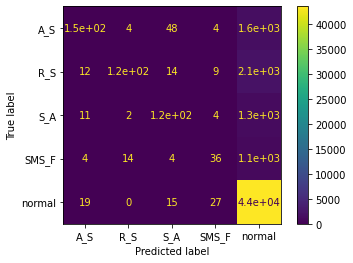

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay

# dizionario
target_dict = {'A_S' : 0,
               'R_S' : 1,
               'S_A' : 2,
               'SMS_F' : 3,
               'normal' : 4
               }

disp = ConfusionMatrixDisplay(cm, target_dict)
disp.plot()

In [26]:
mcm = multilabel_confusion_matrix(y_test, y_pred)
print(mcm)

[[[48423    46]
  [ 1639   154]]

 [[48041    20]
  [ 2086   115]]

 [[48704    81]
  [ 1359   118]]

 [[49080    44]
  [ 1102    36]]

 [[  553  6056]
  [   61 43592]]]


In [27]:
FP = cm.sum (axis = 0) - np.diag (cm) 
FN = cm.sum (axis = 1) - np.diag (cm) 
TP = np.diag (cm) 
TN = cm.sum () - (FP + FN + TP)

print('True positive: ', TP)
print('True negative: ', TN)
print('False positive: ', FP)
print('False negative: ', FN)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)

print('True positive rate: ', TPR)
print('True negative rate: ', TNR)
print('False positive rate: ', FPR)
print('False negative rate: ', FNR)

True positive:  [  154   115   118    36 43592]
True negative:  [48423 48041 48704 49080   553]
False positive:  [  46   20   81   44 6056]
False negative:  [1639 2086 1359 1102   61]
True positive rate:  [0.08588957 0.05224898 0.07989167 0.03163445 0.99860262]
True negative rate:  [0.99905094 0.99958386 0.99833965 0.99910431 0.08367378]
False positive rate:  [9.49060224e-04 4.16137825e-04 1.66034642e-03 8.95692533e-04
 9.16326222e-01]
False negative rate:  [0.91411043 0.94775102 0.92010833 0.96836555 0.00139738]


In [28]:
print(cm)

[[  154     4    48     4  1583]
 [   12   115    14     9  2051]
 [   11     2   118     4  1342]
 [    4    14     4    36  1080]
 [   19     0    15    27 43592]]


In [29]:
print(report)

              precision    recall  f1-score   support

           0       0.77      0.09      0.15      1793
           1       0.85      0.05      0.10      2201
           2       0.59      0.08      0.14      1477
           3       0.45      0.03      0.06      1138
           4       0.88      1.00      0.93     43653

    accuracy                           0.88     50262
   macro avg       0.71      0.25      0.28     50262
weighted avg       0.85      0.88      0.83     50262



In [30]:
print('Accuracy: ', acc)
print('Precision_weighted: ', precision)
print('Recall_weighted: ', recall)
print('mcc: ', mcc)
print('f2: ', f2)

Accuracy:  0.8757112729298476
Precision_weighted:  0.8549541892297756
Recall_weighted:  0.8757112729298476
mcc:  0.2275872575128455
f2:  0.8714796133846204
